In [1]:
from typing import Dict

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
from torch.distributions import Normal
from torch.utils.data import Dataset

In [4]:
from pathlib import Path

In [5]:
from tqdm import tqdm_notebook as tqdm

In [6]:
from torchvision import transforms, datasets

In [7]:
import wget
import os
import requests

In [8]:
import json
import requests

In [9]:
from os import listdir
from os.path import isfile, join

In [10]:
from google_drive_downloader import GoogleDriveDownloader as gd

In [11]:
import tarfile

In [12]:
def download_data(file_id: str, dest_path: str):
    gd.download_file_from_google_drive(file_id=file_id, dest_path=dest_path)
    tar = tarfile.open(dest_path, "r:gz")
    tar.extractall()
    tar.close()
    remove()

In [13]:
# download_data(file_id='1UKApRnqpepFgm9vb8JeqhDvejpqX-tas', dest_path='./anime/faces.tar.gz')

In [14]:
def read_images_content(filepath: Path):
    files = [f for f in listdir(filepath) if isfile(join(filepath, f))]
    dirname = os.path.basename(filepath)
    images = [plt.imread(dirname + '/' + f) for f in files]
    return images

In [15]:
class AnimeDataset(Dataset):
    def __init__(self, data_file: Path, normalizer: float = 255.):
        self.data = read_images_content(data_file) #/ normalizer

    def __getitem__(self, index: int) -> torch.Tensor:
        data = self.data[index]
        return data.mean(axis=2)

    def __len__(self):
        return len(self.data)

In [16]:
data = AnimeDataset(Path('faces/'))

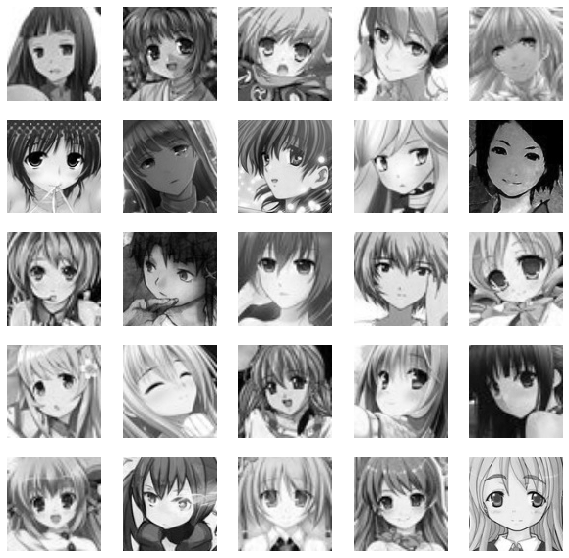

In [17]:
ind = np.random.randint(1, high=len(data), size=25)
pokemons = [data[i] for i in ind]
fig, ax = plt.subplots(5, 5, sharex='col', sharey='row', figsize=(10,10))
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(pokemons[i*5 + j].reshape(96, 96), cmap='gray')
        ax[i,j].axis('off')

In [18]:
batch_size = 10
dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
num_batches = len(dataloader)

In [19]:
IMG_SIZE = 9216
LAYER_SIZE_1 = 512
LAYER_SIZE_2 = 256
LATENT_DIM = 128
EXPAND_DIM = 1024
FEAT_SIZE = 9216
WIDTH = 256
HEIGHT = 256

In [20]:
def loss_function(out, inp, mu, gamma):
    bce = F.binary_cross_entropy(out, inp.view(-1, IMG_SIZE), reduction='mean')
    kld = -0.5 * torch.sum(1 + gamma - mu.pow(2) - gamma.exp())
    batch_size = inp.shape[0]
    kld /= batch_size * IMG_SIZE
    return bce, kld

In [21]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim

        self.mu = nn.Linear(LAYER_SIZE_2, latent_dim)
        self.gamma = nn.Linear(LAYER_SIZE_2, latent_dim)

        self.normal = Normal(loc=0., scale=1.)

        self.encoder = nn.Sequential(
            nn.Linear(IMG_SIZE, LAYER_SIZE_1),
            nn.ReLU(True),
            nn.Linear(LAYER_SIZE_1, LAYER_SIZE_2),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, LAYER_SIZE_2),
            nn.ReLU(True),
            nn.Linear(LAYER_SIZE_2, LAYER_SIZE_1),
            nn.ReLU(True),
            nn.Linear(LAYER_SIZE_1, IMG_SIZE),
            nn.Sigmoid()
        )

    @property
    def device(self) -> torch.device:
        return self.encoder[0].weight.device

    def forward(self, x, *args):
        mu, gamma = self.encode(x.view(-1, IMG_SIZE))
        encoding = self.reparameterize(mu, gamma)
        x = self.decoder(encoding)
        return x, mu, gamma

    def reparameterize(self, mu, gamma):
        if self.training:
            sigma = torch.exp(0.5*gamma)
            std_z = self.normal.sample(sample_shape=sigma.size())
            encoding = std_z.mul(sigma).add(mu)
            return encoding
        else:
            return mu

    def encode(self, x):
        x = self.encoder(x)
        mu = self.mu(x)
        gamma = self.gamma(x)
        return mu, gamma

    def decode(self, x):
        return self.decoder(x)

    def latent(self, x):
        mu, gamma = self.encode(x.view(-1, IMG_SIZE))
        encoding = self.reparameterize(mu, gamma)
        return encoding

    def noise(self, sample_size: int) -> torch.Tensor:
        z = self.normal.sample(sample_shape=(sample_size, self.latent_dim))
        return z
    
    def sample(self, sample_size: int) -> torch.Tensor:
        z = self.noise(sample_size)
        return self.decode(z)

In [22]:
model = VariationalAutoencoder(2)
if torch.cuda.is_available():
    model.cuda()

In [23]:
learning_rate = 0.0002

In [24]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [25]:
def images_to_vectors(images, n_features=IMG_SIZE):
    return images.view(images.size(0), n_features)

In [26]:
def plot_sample_images(generator, cols=5, rows=5, width=96, height=96, figsize=(10, 10)):
    sample = generator.sample(cols * rows).data.cpu().numpy()
    fig, ax = plt.subplots(cols, rows, sharex='col', sharey='row', figsize=figsize)
    for i in range(rows):
        for j in range(cols):
            ax[i,j].imshow(sample[i*rows + j].reshape(width, height), cmap='gray')
            ax[i,j].axis('off')

In [27]:
def train_vae(num_epochs=100):
    device = model.device
    losses = []
    for epoch in range(num_epochs):
        print(f'\r epoch: [{epoch+1}/{num_epochs}]', end='')
        loss, b = 0, 0
        for batch in tqdm(dataloader, ncols=340, desc=f'Epoch {epoch + 1}'):
            inp = images_to_vectors(batch).to(device).float()
            sample_size = inp.size(0)
            out, mu, gamma = model(inp)
            bce, kld = loss_function(out, inp, mu, gamma)
            total_loss = bce + kld
            total_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss += total_loss.data.cpu()
            b += 1
        loss /= float(b)
        losses.append(loss)
        plot_sample_images(model)
    return losses

In [ ]:
num_epochs = 10
losses = train_vae(num_epochs=num_epochs)

 epoch: [1/10]

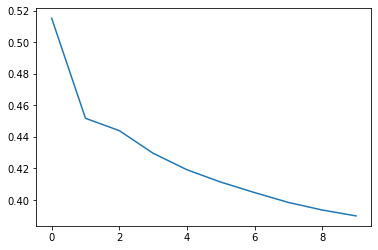

In [109]:
plt.plot(losses);

In [110]:
pokemons = model.sample(25).data.cpu().numpy()

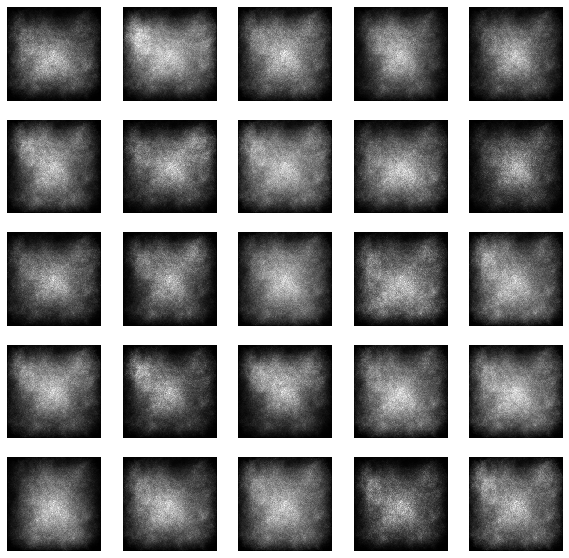

In [111]:
fig, ax = plt.subplots(5, 5, sharex='col', sharey='row', figsize=(10,10))
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(pokemons[i*5 + j].reshape(256, 256), cmap='gray')
        ax[i,j].axis('off')

In [90]:
def image_normalize(img):
    img_min = img.min()
    img_max = img.max()
    if img_min < img_max:
        img = (img - img_min) / (img_max - img_min)
    return img

In [91]:
def to_image_tensor(input_tensor, n_rows=15, n_cols=15, width=256, height=256):
    images_to_plot = n_rows * n_cols
    tensor_to_plot = input_tensor[:images_to_plot, :]
    image_grid = np.zeros((1, n_rows * height, n_cols * width))
    for i in range(images_to_plot):
        r = i//n_rows
        c = i%n_cols
        image_grid[:, r * height:(r + 1) * height, c * width:(c + 1) * width] = tensor_to_plot[i, :].reshape(1, width, height)
    return torch.Tensor(image_normalize(image_grid))

In [92]:
def latent_space_embeddings(size: int, sigma: float = 1.) -> torch.Tensor:
    x_values = np.linspace(-3 * sigma, 3 * sigma, size)
    y_values = np.linspace(-3 * sigma, 3 * sigma, size)
    xx, yy = np.meshgrid(x_values, y_values)
    xx, yy = xx.reshape(-1), yy.reshape(-1)
    grid = np.vstack((xx, yy)).T
    return torch.FloatTensor(grid)

In [93]:
def sample_latent_space_embeddings(model: nn.Module, sample_size: int) -> torch.Tensor:
    with torch.no_grad():
        size = int(np.sqrt(sample_size))
        model.train(False)
        device = model.device
        grid = latent_space_embeddings(size)
        grid = grid.view(grid.size(0), -1).to(device)
        generated_batch = model.decode(grid)
        generated_grid = to_image_tensor(generated_batch.cpu(), n_cols=size, n_rows=size)
        return generated_grid

In [98]:
images = sample_latent_space_embeddings(model, 225).squeeze()

RuntimeError: shape '[256, 256]' is invalid for input of size 3840

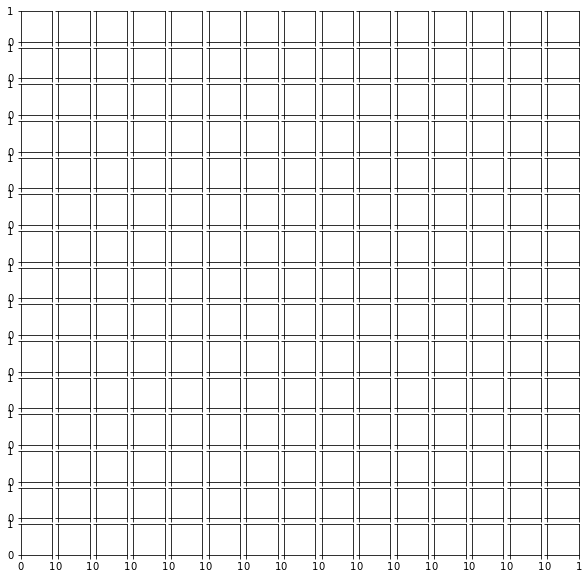

In [101]:
fig, ax = plt.subplots(15, 15, sharex='col', sharey='row', figsize=(10,10))
for i in range(15):
    for j in range(15):
        ax[i,j].imshow(images[i*15 + j].reshape(256, 256), cmap='gray')
        ax[i,j].axis('off')